# Setup

In [57]:
import pandas as pd
import numpy as np
from scipy.special import logit, expit
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from copy import deepcopy
import geopandas as gpd
import matplotlib.pyplot as plt
import shap

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [58]:
# Read datasetsetset and create latitude/longitude columns
dataset = pd.read_csv("./seattle_sample_500.csv")
dataset = gpd.GeoDataFrame(dataset, crs="EPSG:32610", geometry=gpd.points_from_xy(x=dataset.UTM_X, y=dataset.UTM_Y))
dataset = dataset.to_crs(4326) # Coordinates in lat/lon
dataset['lon'] = dataset['geometry'].get_coordinates()['x']
dataset['lat'] = dataset['geometry'].get_coordinates()['y']

y = dataset.high_price
X_coords = dataset[['bathrooms', 'sqft_living', 'sqft_lot', 'grade', 'condition', 'waterfront', 'view', 'age', 'lon', 'lat']]

print(y.head())
print(X_coords.head())

0    1
1    1
2    0
3    0
4    0
Name: high_price, dtype: int64
   bathrooms  sqft_living  sqft_lot  grade  condition  waterfront  view  age  \
0       3.00         2660      4600      8          3           0     0  109   
1       2.25         2530      8736      7          4           0     0   57   
2       2.00         1390     13464      7          4           0     0   28   
3       1.00          940      4264      7          5           0     0   66   
4       2.25         2070      7225      8          3           0     0   36   

       lon      lat  
0 -122.305  47.6258  
1 -122.126  47.6049  
2 -122.173  47.3581  
3 -122.378  47.5314  
4 -122.148  47.3551  


In [59]:
# Train/test split: 80/20
X_train, X_test, y_train, y_test = train_test_split(X_coords, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(X_test.head())
print(y_test.head())
X_train_raw = deepcopy(X_train)
X_test_raw = deepcopy(X_test)

# Pipeline for scaling
pipe = Pipeline([
    ("scaler", StandardScaler()),
    # Fit logistic regression model
    # clf = LogisticRegression(max_iter=600, solver="lbfgs").fit(X_train, y_train)
    ("clf", LogisticRegression(max_iter=600, solver="lbfgs"))
])
pipe.fit(X_train_raw, y_train)
print(f"Model score on test set: {pipe.score(X_test, y_test)}")

# Scaled versions for SHAP computation
X_train_scaled = pipe["scaler"].transform(X_train_raw) # numpy array
X_test_scaled  = pipe["scaler"].transform(X_test_raw)
print("Scaled X_train: ", X_train_scaled[:5])
print("Raw X_train: ", X_train_raw.iloc[:5])

# Background via kmeans
background = shap.kmeans(X_train_raw, k=50)

# Model prediction function for scaled data
def model_proba_scaled(X):
    return pipe.predict_proba(X)[:, 1]  # Probability of class 1
def model_proba_2(X):
    return pipe.predict_proba(X)  # Probabilities of both classes

# Pick a test instance
to_explain = 5
x = X_test_raw[to_explain:to_explain+1] # as 2D array
print(f"Unscaled test instance to explain:\n{X_test_raw.iloc[[to_explain]]}")

feature_names = X_coords.columns.tolist()

(400, 10) (100, 10) (400,) (100,)
     bathrooms  sqft_living  sqft_lot  grade  condition  waterfront  view  \
361       1.75         1140      3395      7          5           0     0   
73        2.50         1256      1154      7          3           0     0   
374       1.00          920      8341      7          3           0     0   
155       1.75         2430      5481      8          3           0     0   
104       1.50         1760      6723      7          3           0     0   

     age      lon      lat  
361   90 -122.393  47.6712  
73    10 -122.311  47.7146  
374   76 -122.380  47.5015  
155   62 -122.298  47.5569  
104   57 -122.266  47.5514  
361    0
73     0
374    0
155    0
104    0
Name: high_price, dtype: int64
Model score on test set: 0.82
Scaled X_train:  [[-0.0469841   1.18311458 -0.55373764  1.29371987  0.72489772 -0.07088812
  -0.28290145  1.95377213 -0.61440683  0.46094725]
 [ 1.2059252   0.54327559  1.82606012  0.38425072  0.72489772 -0.07088812
  -0.28

We only care about the 'high price' label (feature contributions would just be negative for low price)

# BayesSHAP explanation
(for single row of data)

In [60]:
from bayesshap import BayesSHAPTabular

# data has to be numpy array
x_row = X_test.iloc[to_explain].values #1D row vector
print("X_row", x_row) #raw value

# initialize class
exp = BayesSHAPTabular(
    model = pipe,
    background = background.data, # same will be used for KernelSHAP
    n_perturb = 2000,
    n_posterior = 2000,
    cred_level = 0.95,
    random_state = 0
)

def run_bayes(label):
    out = exp.explain(
        x = x_row,
        label = label
    )
    means = out["phi_mean"]
    lower = out["phi_ci_lower"]
    upper = out["phi_ci_upper"]
    baseline = out["baseline"]
    
    return means, lower, upper, baseline

mean0, lo0, hi0, base0 = run_bayes(0)
mean1, lo1, hi1, base1 = run_bayes(1)

print(mean1)
print(lo1)
print(hi1)

X_row [ 4.50000e+00  4.06000e+03  1.08000e+04  1.00000e+01  3.00000e+00
  0.00000e+00  0.00000e+00  8.00000e+00 -1.22290e+02  4.74241e+01]
[-0.03736523  0.35834422 -0.0444379   0.3991653   0.02554375 -0.03011337
 -0.05736368 -0.11524674  0.00692949 -0.10603574]
[-0.06686403  0.32582395 -0.07499653  0.36676391 -0.0112945  -0.06103324
 -0.08795927 -0.14679673 -0.02393444 -0.13579706]
[-0.00666116  0.39123856 -0.01432766  0.43320107  0.06236864  0.00219589
 -0.02503654 -0.08434763  0.03935811 -0.07684088]


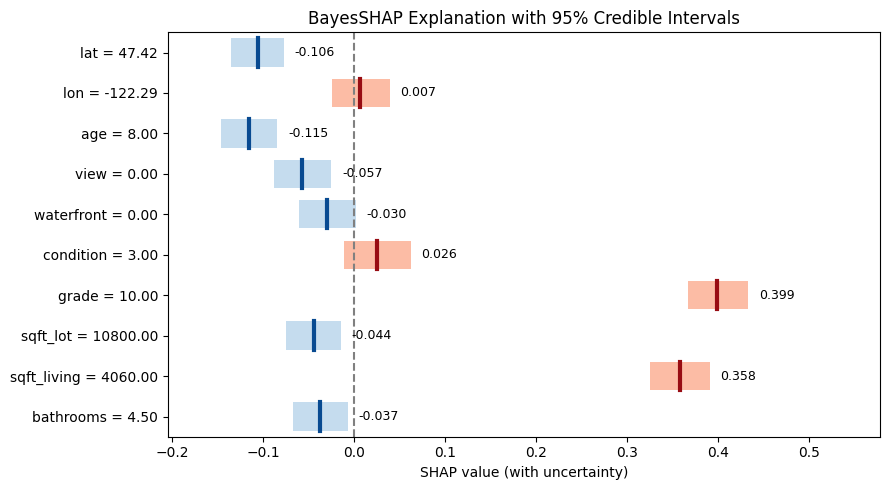

In [61]:
# Plot
import matplotlib.pyplot as plt
from matplotlib import cm

def plot_shap_uncertainty(X_row, mean1, lo1, hi1, feature_names):
    n_features = len(mean1)
    y_pos = np.arange(n_features)

    fig, ax = plt.subplots(figsize=(9, 5))

    x_min = np.min(lo1)
    x_max = np.max(hi1)
    x_range = x_max - x_min if x_max != x_min else 1

    for j in range(n_features):
        y = y_pos[j]
        m = mean1[j]
        lo = lo1[j]
        hi = hi1[j]

        # Choose color by sign of mean SHAP
        cmap = cm.Reds if m >= 0 else cm.Blues

        # Interval bar 
        ax.fill_betweenx(
            [y - 0.35, y + 0.35],
            lo, hi,
            color=cmap(0.3),
            alpha=0.8,
            linewidth=0
        )

        # Vertical line at mean SHAP
        ax.plot([m, m], [y - 0.35, y + 0.35],
                color=cmap(0.9),
                linewidth=3)

        # SHAP value label
        ax.text(
            hi + 0.02 * x_range,
            y,
            f"{m:.3f}",
            va="center",
            ha="left",
            fontsize=9
        )

    # Feature labels as "name = value"
    ax.set_yticks(y_pos)
    ax.set_yticklabels([
        f"{name} = {float(val):.2f}" for name, val in zip(feature_names, X_row)
    ])

    # Zero-reference line
    ax.axvline(0, linestyle="--", color="gray")

    ax.set_xlabel("SHAP value (with uncertainty)")
    ax.set_ylim(-0.5, n_features - 0.5)
    ax.set_xlim(x_min - 0.1 * x_range,
                x_max + 0.25 * x_range)

    plt.title("BayesSHAP Explanation with 95% Credible Intervals")
    plt.tight_layout()
    plt.show()

plot_shap_uncertainty(x_row, mean1, lo1, hi1, feature_names)

In [62]:
# Fidelity test (reconstruction)
real_label = y_test.iloc[[to_explain]].values[0]
print("Real label:", real_label)
print(x)
p1_model = model_proba_scaled(x.values)[0]
print(p1_model)
fidelity = abs(p1_model - (base1 + np.sum(mean1)))  # or base1 + sum(mean1)
print("Fidelity (|model prob - reconstructed prob|):", fidelity)

Real label: 1
     bathrooms  sqft_living  sqft_lot  grade  condition  waterfront  view  \
394        4.5         4060     10800     10          3           0     0   

     age     lon      lat  
394    8 -122.29  47.4241  
0.8901606347966302
Fidelity (|model prob - reconstructed prob|): 0.05253474879800124


#### Validation with N = 10000

[-0.01726591  0.38039317 -0.05345612  0.44842893 -0.060358   -0.0120528
 -0.03959054 -0.12888628 -0.03298533 -0.13787657]
[-0.0278015   0.37004856 -0.0634689   0.43790752 -0.07046591 -0.02233262
 -0.04982391 -0.13857742 -0.04283302 -0.14803799]
[-0.00666921  0.39015807 -0.04349972  0.45836001 -0.05024711 -0.00228389
 -0.02977584 -0.11860044 -0.02332397 -0.12795124]


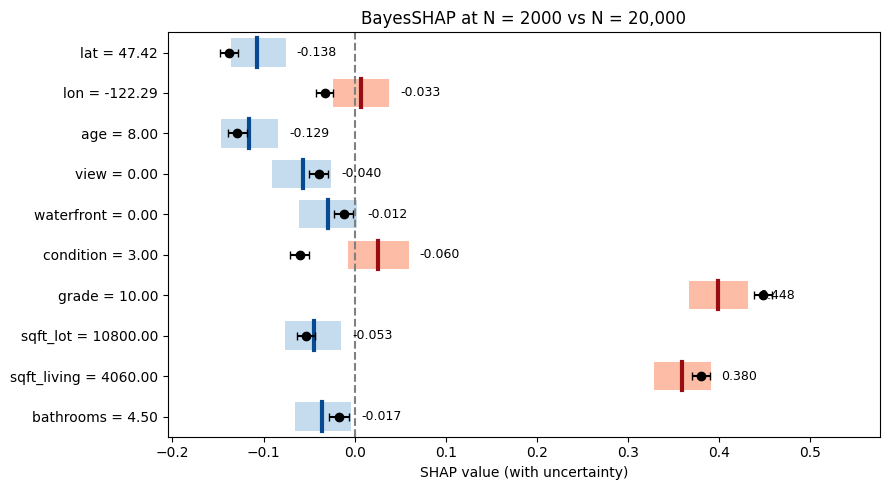

In [45]:
# initialize class
exp = BayesSHAPTabular(
    model = pipe,
    background = background.data, # same will be used for KernelSHAP
    n_perturb = 20000,
    n_posterior = 2000,
    cred_level = 0.95,
    random_state = 0
)

out = exp.explain(
    x = x_row,
    label = 1
)
means = out["phi_mean"]
lower = out["phi_ci_lower"]
upper = out["phi_ci_upper"]
baseline = out["baseline"]

print(means)
print(lower)
print(upper)

# similar plot function to above
n_features = len(mean1)
y_pos = np.arange(n_features)

fig, ax = plt.subplots(figsize=(9, 5))

x_min = np.min(lo1)
x_max = np.max(hi1)
x_range = x_max - x_min if x_max != x_min else 1

for j in range(n_features):
    y = y_pos[j]
    m = mean1[j]
    true_m = means[j]
    lo = lo1[j]
    hi = hi1[j]

    # Choose color by sign of mean SHAP
    cmap = cm.Reds if m >= 0 else cm.Blues

    # BayesSHAP Interval bar 
    ax.fill_betweenx(
        [y - 0.35, y + 0.35],
        lo, hi,
        color=cmap(0.3),
        alpha=0.8,
        linewidth=0
    )

    # Vertical line at mean SHAP
    ax.plot([m, m], [y - 0.35, y + 0.35],
            color=cmap(0.9),
            linewidth=3)

    # SHAP value label
    ax.text(
        hi + 0.02 * x_range,
        y,
        f"{true_m:.3f}",
        va="center",
        ha="left",
        fontsize=9
    )

# Show true feature importance as error bar/point
plt.errorbar(
    x = means,
    y = feature_names,
    xerr = [means - lower, upper - means],
    fmt = 'o', capsize=3, color='black'
)

# Feature labels as "name = value"
ax.set_yticks(y_pos)
ax.set_yticklabels([
    f"{name} = {float(val):.2f}" for name, val in zip(feature_names, x_row)
])

# Zero-reference line
ax.axvline(0, linestyle="--", color="gray")

ax.set_xlabel("SHAP value (with uncertainty)")
ax.set_ylim(-0.5, n_features - 0.5)
ax.set_xlim(x_min - 0.1 * x_range,
            x_max + 0.25 * x_range)

plt.title("BayesSHAP at N = 2000 vs N = 20,000")
plt.tight_layout()
plt.show()


# Comparison to KernelSHAP

In [63]:
explainer = shap.KernelExplainer(model_proba_scaled, background.data, feature_names=feature_names)
print(x)
shap_values = explainer.shap_values(x, nsamples="auto")
phi0 = explainer.expected_value
print(shap_values)

     bathrooms  sqft_living  sqft_lot  grade  condition  waterfront  view  \
394        4.5         4060     10800     10          3           0     0   

     age     lon      lat  
394    8 -122.29  47.4241  


100%|██████████| 1/1 [00:00<00:00, 57.76it/s]

[[-1.56176390e-03  3.36964287e-01 -2.93421905e-02  4.28226689e-01
  -1.87791546e-02 -3.46346927e-04 -9.70676990e-03 -1.28552508e-01
  -1.71002677e-02 -1.40091919e-01]]


In [64]:
# Split results by label
phi0_1= phi0
phi_1 = shap_values[0] # Feature contributions for 'high_price = 1' label
print(phi0_1)
print(phi_1)

# model proabability for 'high price' label
p1_model = model_proba_scaled(x.values)[0]
# SHAP reconstruction
p1_recon = phi0_1 + phi_1.sum()

print(f"class 1: model={p1_model:.6f}, recon={p1_recon:.6f}, abs err={abs(p1_model-p1_recon):.3e}")
print(f"REAL label: {y_test.iloc[[to_explain]].values}")

0.4704505787707788
[-1.56176390e-03  3.36964287e-01 -2.93421905e-02  4.28226689e-01
 -1.87791546e-02 -3.46346927e-04 -9.70676990e-03 -1.28552508e-01
 -1.71002677e-02 -1.40091919e-01]
class 1: model=0.890161, recon=0.890161, abs err=0.000e+00
REAL label: [1]


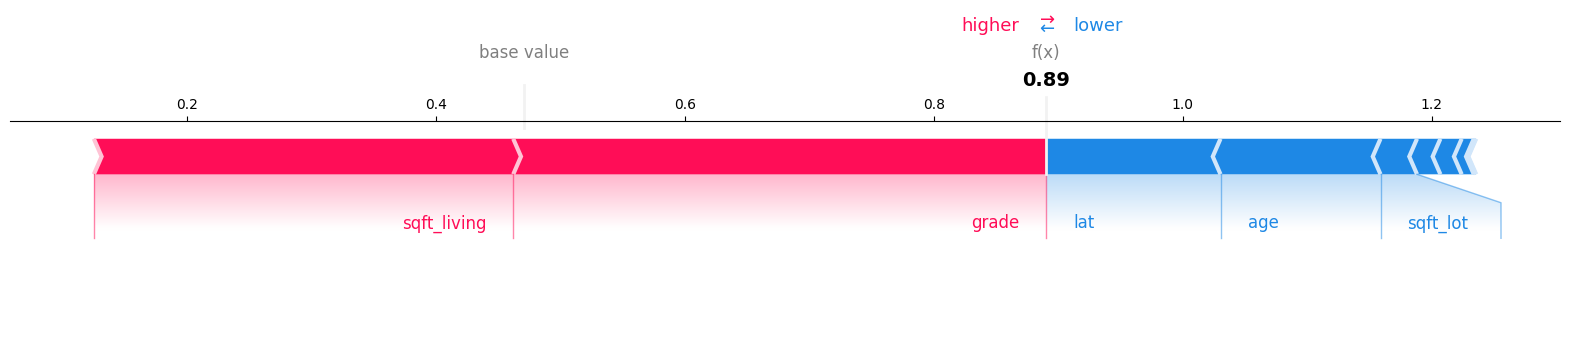

In [8]:
# For class 1
shap.plots.force(explainer.expected_value, shap_values, feature_names=feature_names, matplotlib=True)

# Comparison to LIME

In [65]:
import lime
import lime.lime_tabular

X_train_np = X_train.to_numpy()
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train_np, feature_names=feature_names, verbose=True, mode='classification')
lime_exp = lime_explainer.explain_instance(x_row, model_proba_2)

from IPython.display import display, HTML

html = lime_exp.as_html()
display(HTML(html))

Intercept 0.6104074012546725
Prediction_local [0.54570244]
Right: 0.8901606347966302


In [66]:
# feature contrib values
print(lime_exp.as_list())

# get an unsorted list of just the feature contribs
lime_vals = list(map(lambda t: t[1], lime_exp.as_list()))
label = lime_exp.available_labels()[0]
pairs = lime_exp.local_exp[label]
d = X_test.shape[1]
lime_unsorted = np.zeros(d)
for idx, contrib in pairs:
    lime_unsorted[idx] = contrib 
print(lime_unsorted) 
print(pairs)

[('grade > 8.00', 0.48032934129956323), ('sqft_living > 2440.00', 0.2744548420007526), ('lat <= 47.50', -0.2550240201328349), ('age <= 24.75', -0.17528887709723995), ('view <= 0.00', -0.14861674896745072), ('sqft_lot > 9207.50', -0.1241830121682497), ('waterfront <= 0.00', -0.09033776557109796), ('condition <= 3.00', -0.05569205553525973), ('-122.29 < lon <= -122.19', 0.027034353911967623), ('bathrooms > 2.50', 0.002618982252733845)]
[ 0.00261898  0.27445484 -0.12418301  0.48032934 -0.05569206 -0.09033777
 -0.14861675 -0.17528888  0.02703435 -0.25502402]
[(np.int64(3), np.float64(0.48032934129956323)), (np.int64(1), np.float64(0.2744548420007526)), (np.int64(9), np.float64(-0.2550240201328349)), (np.int64(7), np.float64(-0.17528887709723995)), (np.int64(6), np.float64(-0.14861674896745072)), (np.int64(2), np.float64(-0.1241830121682497)), (np.int64(5), np.float64(-0.09033776557109796)), (np.int64(4), np.float64(-0.05569205553525973)), (np.int64(8), np.float64(0.027034353911967623)), (n

In [67]:
# fidelity test
p1_recon_lime = lime_exp.intercept[label] + np.sum(lime_unsorted)
print("LIME reconstruction prob:", p1_recon_lime)
fidelity = abs(p1_model - p1_recon_lime)
print("Fidelity (|model prob - reconstructed prob|):", fidelity)

LIME reconstruction prob: 0.5457024412475567
Fidelity (|model prob - reconstructed prob|): 0.3444581935490735


# Side-by-side comparison of all three methods

In [12]:
# for the 1 label, single data instance
single_cmp = pd.DataFrame({"actual value": x_row.flatten(),
                    "feature": feature_names,
                     "kernel shap": phi_1,
                     "bayes_mean": mean1,
                     "bayes_lowerbound": lo1,
                     "bayes_upperbound": hi1,
                     "lime": lime_unsorted,
                     "KernelSHAP in CI?": (lo1 <= phi_1) & (phi_1 <= hi1),
                     "LIME in CI?": (lo1 <= lime_unsorted) & (lime_unsorted <= hi1),
                     "|LIME - KernelSHAP|/KernelSHAP": np.abs(lime_unsorted - phi_1)/np.abs(phi_1)})
display(HTML(single_cmp.to_html(max_cols=None)))

,actual value,feature,kernel shap,bayes_mean,bayes_lowerbound,bayes_upperbound,lime,KernelSHAP in CI?,LIME in CI?,|LIME - KernelSHAP|/KernelSHAP
0,4.5000,bathrooms,-0.001562,-0.036746,-0.068880,-0.007278,0.001765,False,False,2.129936
1,4060.0000,sqft_living,0.336964,0.358939,0.327574,0.389753,0.280283,True,False,0.168213
2,10800.0000,sqft_lot,-0.029342,-0.044535,-0.075833,-0.014563,-0.124141,True,False,3.230802
3,10.0000,grade,0.428227,0.398049,0.366397,0.427937,0.492611,False,False,0.150352
4,3.0000,condition,-0.018779,0.025222,-0.010236,0.059246,-0.062182,False,False,2.311223
5,0.0000,waterfront,-0.000346,-0.029720,-0.062463,0.002822,-0.183605,True,False,529.119955
6,0.0000,view,-0.009707,-0.057428,-0.087269,-0.024898,-0.121045,False,False,11.470168
7,8.0000,age,-0.128553,-0.115182,-0.145860,-0.082750,-0.185765,True,False,0.445052
8,-122.2900,lon,-0.017100,0.007304,-0.025749,0.039880,0.007706,True,True,1.450616
9,47.4241,lat,-0.140092,-0.106235,-0.135520,-0.075166,-0.257766,False,False,0.839974


### Repeat for all points in the test dataset

Model predicts 1 if P(class 1) > 0.5. Remove all incorrect predictions

In [13]:
def run_bayes(label, x_row):
    out = exp.explain(
        x = x_row,
        label = label
    )
    means = out["phi_mean"]
    lower = out["phi_ci_lower"]
    upper = out["phi_ci_upper"]
    baseline = out["baseline"]
    
    return means, lower, upper, baseline

full_comparison = []
predicted_vs_real = []
for i in range(X_test.shape[0]):
    # Drop points that are misclassified
    real_label = y_test.iloc[[i]].values[0]
    x_row = X_test.iloc[[i]].values
    p1_model = model_proba_scaled(x_row)[0]

    if ((real_label == 1 and p1_model > 0.5) or (real_label == 0 and p1_model < 0.5)):
        x = X_test_raw[i:i+1] # as 2D array

        # Kernel SHAP
        shap_values = explainer.shap_values(x, nsamples="auto")
        phi = shap_values[0]          
        phi0 = explainer.expected_value

        # BayesSHAP
        x_row = X_test.iloc[i].values #1D row vector
        #mean0, lo0, hi0, base0 = run_bayes(0, x_row)
        mean1, lo1, hi1, base1 = run_bayes(1, x_row)

        # LIME
        lime_exp = lime_explainer.explain_instance(x_row, model_proba_2)
        label = lime_exp.available_labels()[0]
        pairs = lime_exp.local_exp[label]
        d = X_test.shape[1]
        lime_unsorted = np.zeros(d)
        for idx, contrib in pairs:
            lime_unsorted[idx] = contrib 

        # Comparison for 1 label
        single_cmp = pd.DataFrame({"feature num": i,
                        "feature": feature_names,
                        "kernel shap": phi,
                        "bayes_mean": mean1,
                        "bayes_lowerbound": lo1,
                        "bayes_upperbound": hi1,
                        "lime": lime_unsorted,
                        "KernelSHAP in CI?": (lo1 <= phi) & (phi <= hi1),
                        "LIME in CI?": (lo1 <= lime_unsorted) & (lime_unsorted <= hi1),
                        "|LIME - KernelSHAP|/KernelSHAP": np.abs(lime_unsorted - phi_1)/np.abs(phi_1)})
        full_comparison.append(single_cmp)
    sing_pvr = pd.DataFrame({
        "real label": real_label,
        "predicted prob class 1": p1_model
    }, index=[i])
    predicted_vs_real.append(sing_pvr)
        

comparison_df = pd.concat(full_comparison, ignore_index=True)
predicted_vs_real_df = pd.concat(predicted_vs_real, ignore_index=True)

100%|██████████| 1/1 [00:00<00:00, 55.65it/s]


Intercept 0.8114772184529778
Prediction_local [0.35340727]
Right: 0.48617281753036395


100%|██████████| 1/1 [00:00<00:00, 58.22it/s]


Intercept 0.8542666537565864
Prediction_local [0.13473332]
Right: 0.08771737274538977


100%|██████████| 1/1 [00:00<00:00, 74.52it/s]


Intercept 0.89074175921389
Prediction_local [-0.04932635]
Right: 0.01376514686679221


100%|██████████| 1/1 [00:00<00:00, 56.71it/s]


Intercept 0.9184675993448097
Prediction_local [0.12924559]
Right: 0.08802023829612815


100%|██████████| 1/1 [00:00<00:00, 54.12it/s]


Intercept 0.7516670519749762
Prediction_local [0.51434315]
Right: 0.8901606347966302


100%|██████████| 1/1 [00:00<00:00, 57.84it/s]


Intercept 0.6384654889052377
Prediction_local [0.30939398]
Right: 0.17495470740935487


100%|██████████| 1/1 [00:00<00:00, 57.37it/s]


Intercept 0.9668488157826037
Prediction_local [-0.23319562]
Right: 0.0020513431667682014


100%|██████████| 1/1 [00:00<00:00, 56.36it/s]


Intercept 0.7519891273009038
Prediction_local [0.5380937]
Right: 0.5939698295135222


100%|██████████| 1/1 [00:00<00:00, 56.84it/s]


Intercept 1.0190902393130936
Prediction_local [0.02732437]
Right: 0.00040669973936698317


100%|██████████| 1/1 [00:00<00:00, 55.17it/s]


Intercept 0.868256116065705
Prediction_local [0.14226198]
Right: 0.15812453876555602


100%|██████████| 1/1 [00:00<00:00, 58.99it/s]


Intercept 0.8771064316893336
Prediction_local [-0.01489938]
Right: 0.02751221650299602


100%|██████████| 1/1 [00:00<00:00, 55.51it/s]


Intercept 0.801212367639899
Prediction_local [0.33335124]
Right: 0.5069188578109718


100%|██████████| 1/1 [00:00<00:00, 56.72it/s]


Intercept 0.9702010353148867
Prediction_local [-0.05713962]
Right: 0.008848214946954905


100%|██████████| 1/1 [00:00<00:00, 54.97it/s]


Intercept 0.8023415014309956
Prediction_local [0.27782029]
Right: 0.27142304558605


100%|██████████| 1/1 [00:00<00:00, 61.95it/s]


Intercept 0.504404824794479
Prediction_local [1.09096137]
Right: 0.9859973426203834


100%|██████████| 1/1 [00:00<00:00, 56.63it/s]


Intercept 0.7313446479911752
Prediction_local [0.15765263]
Right: 0.042649066876878666


100%|██████████| 1/1 [00:00<00:00, 62.34it/s]


Intercept 0.9280850427095663
Prediction_local [-0.28383414]
Right: 0.0016472505897356868


100%|██████████| 1/1 [00:00<00:00, 57.65it/s]


Intercept 0.9952125029251863
Prediction_local [-0.08454923]
Right: 0.023517952559180277


100%|██████████| 1/1 [00:00<00:00, 63.88it/s]


Intercept 0.6059782877289126
Prediction_local [0.75525406]
Right: 0.7857168852309457


100%|██████████| 1/1 [00:00<00:00, 54.61it/s]


Intercept 0.7122595804222916
Prediction_local [0.48084618]
Right: 0.6285716972152797


100%|██████████| 1/1 [00:00<00:00, 56.61it/s]


Intercept 0.5178277272312553
Prediction_local [0.71104873]
Right: 0.8017735620145705


100%|██████████| 1/1 [00:00<00:00, 61.84it/s]


Intercept 0.8849594566047796
Prediction_local [0.14054599]
Right: 0.0567506468702881


100%|██████████| 1/1 [00:00<00:00, 56.21it/s]


Intercept 0.541748591610719
Prediction_local [0.82430247]
Right: 0.8795308427542265


100%|██████████| 1/1 [00:00<00:00, 48.53it/s]


Intercept 0.5419948287876193
Prediction_local [0.62209776]
Right: 0.9662666573604656


100%|██████████| 1/1 [00:00<00:00, 58.85it/s]


Intercept 0.45894436194891364
Prediction_local [0.85585951]
Right: 0.9526782344137197


100%|██████████| 1/1 [00:00<00:00, 59.84it/s]


Intercept 0.6326453957056177
Prediction_local [0.19399526]
Right: 0.07984159324435355


100%|██████████| 1/1 [00:00<00:00, 62.92it/s]


Intercept 0.8507521824939294
Prediction_local [0.01999616]
Right: 0.040829254543370844


100%|██████████| 1/1 [00:00<00:00, 61.45it/s]


Intercept 0.645151473891346
Prediction_local [0.47212737]
Right: 0.7051317043838203


100%|██████████| 1/1 [00:00<00:00, 52.11it/s]


Intercept 0.9784344896771581
Prediction_local [-0.15253984]
Right: 0.0018044003745229637


100%|██████████| 1/1 [00:00<00:00, 61.94it/s]


Intercept 0.9001093068626678
Prediction_local [-0.09300912]
Right: 0.020212667696663557


100%|██████████| 1/1 [00:00<00:00, 52.42it/s]


Intercept 0.8173095493515841
Prediction_local [0.16224489]
Right: 0.0278144339613206


100%|██████████| 1/1 [00:00<00:00, 56.10it/s]


Intercept 0.9675135029428407
Prediction_local [-0.18581083]
Right: 0.012228236498751006


100%|██████████| 1/1 [00:00<00:00, 66.43it/s]


Intercept 0.8728010639154037
Prediction_local [-0.01332649]
Right: 0.00428510187158218


100%|██████████| 1/1 [00:00<00:00, 61.66it/s]


Intercept 0.44412980517577966
Prediction_local [0.9198344]
Right: 0.9073964022580463


100%|██████████| 1/1 [00:00<00:00, 60.71it/s]


Intercept 0.7442840836479732
Prediction_local [0.22134975]
Right: 0.3659462382038521


100%|██████████| 1/1 [00:00<00:00, 67.86it/s]


Intercept 0.42109123958933115
Prediction_local [0.79653679]
Right: 0.9558963173326701


100%|██████████| 1/1 [00:00<00:00, 51.34it/s]


Intercept 0.8599084598469261
Prediction_local [-0.06001808]
Right: 0.01418519255548167


100%|██████████| 1/1 [00:00<00:00, 57.13it/s]


Intercept 0.8457786500427518
Prediction_local [0.00552232]
Right: 0.005341417486211808


100%|██████████| 1/1 [00:00<00:00, 58.79it/s]


Intercept 0.8674944332513068
Prediction_local [-0.04350028]
Right: 0.007998515936833941


100%|██████████| 1/1 [00:00<00:00, 61.24it/s]


Intercept 0.3523148259565416
Prediction_local [0.97780964]
Right: 0.9709083427408767


100%|██████████| 1/1 [00:00<00:00, 54.72it/s]


Intercept 0.6679290802916
Prediction_local [0.0716485]
Right: 0.010727613425353588


100%|██████████| 1/1 [00:00<00:00, 55.61it/s]


Intercept 0.7921130037483411
Prediction_local [0.08048523]
Right: 0.0318300617678406


100%|██████████| 1/1 [00:00<00:00, 63.75it/s]


Intercept 0.8348851212153052
Prediction_local [0.23796747]
Right: 0.024118627122889164


100%|██████████| 1/1 [00:00<00:00, 67.46it/s]


Intercept 0.48625120335947936
Prediction_local [0.85626238]
Right: 0.999572932441592


100%|██████████| 1/1 [00:00<00:00, 59.69it/s]


Intercept 0.9310546014971302
Prediction_local [-0.15003012]
Right: 0.020871669497915545


100%|██████████| 1/1 [00:00<00:00, 61.30it/s]


Intercept 0.9107210854387969
Prediction_local [0.19929283]
Right: 0.20624505721603828


100%|██████████| 1/1 [00:00<00:00, 57.48it/s]


Intercept 0.8657983896148891
Prediction_local [0.03301546]
Right: 0.006352993863401629


100%|██████████| 1/1 [00:00<00:00, 56.54it/s]


Intercept 0.4736962446070724
Prediction_local [0.74795946]
Right: 0.7347461711117883


100%|██████████| 1/1 [00:00<00:00, 58.43it/s]


Intercept 0.3080505577614972
Prediction_local [1.1537567]
Right: 0.9967569566781421


100%|██████████| 1/1 [00:00<00:00, 61.91it/s]


Intercept 0.6532907215433076
Prediction_local [0.4221571]
Right: 0.17711406640493213


100%|██████████| 1/1 [00:00<00:00, 63.64it/s]


Intercept 0.40300410228623446
Prediction_local [0.94271049]
Right: 0.9505794421942999


100%|██████████| 1/1 [00:00<00:00, 55.82it/s]


Intercept 0.7482574945919456
Prediction_local [0.41416574]
Right: 0.46588437712720754


100%|██████████| 1/1 [00:00<00:00, 53.81it/s]


Intercept 0.6847976504391527
Prediction_local [0.19975328]
Right: 0.05342041879277069


100%|██████████| 1/1 [00:00<00:00, 67.54it/s]


Intercept 0.7169782459825285
Prediction_local [0.29212011]
Right: 0.21449535555198068


100%|██████████| 1/1 [00:00<00:00, 60.99it/s]


Intercept 0.784572258054817
Prediction_local [0.3856756]
Right: 0.3622745624455969


100%|██████████| 1/1 [00:00<00:00, 54.67it/s]


Intercept 0.672628426652643
Prediction_local [0.17377792]
Right: 0.016936127765442642


100%|██████████| 1/1 [00:00<00:00, 58.13it/s]


Intercept 0.9222414316098256
Prediction_local [-0.02138813]
Right: 0.0029791999258388722


100%|██████████| 1/1 [00:00<00:00, 56.65it/s]


Intercept 0.6040407649314621
Prediction_local [0.21376851]
Right: 0.019369433137565676


100%|██████████| 1/1 [00:00<00:00, 55.61it/s]


Intercept 0.9319603568835051
Prediction_local [-0.10931002]
Right: 0.0038703287973538714


100%|██████████| 1/1 [00:00<00:00, 57.77it/s]


Intercept 0.32540592675281066
Prediction_local [0.87319729]
Right: 0.9848476934240273


100%|██████████| 1/1 [00:00<00:00, 58.53it/s]


Intercept 0.5404620057685013
Prediction_local [0.85187144]
Right: 0.9890601738560171


100%|██████████| 1/1 [00:00<00:00, 57.30it/s]


Intercept 0.8197759186062106
Prediction_local [0.24927299]
Right: 0.13473603711925822


100%|██████████| 1/1 [00:00<00:00, 54.90it/s]


Intercept 0.7287082672239995
Prediction_local [0.38388333]
Right: 0.40056504529631104


100%|██████████| 1/1 [00:00<00:00, 59.61it/s]


Intercept 0.3361803726696369
Prediction_local [0.85875794]
Right: 0.9832417894194232


100%|██████████| 1/1 [00:00<00:00, 52.29it/s]


Intercept 0.8862331179434576
Prediction_local [0.17189623]
Right: 0.2505119605439939


100%|██████████| 1/1 [00:00<00:00, 46.37it/s]


Intercept 0.9484188593741868
Prediction_local [0.06321678]
Right: 0.0004844751162709043


100%|██████████| 1/1 [00:00<00:00, 45.65it/s]


Intercept 0.5392919346689887
Prediction_local [0.54141567]
Right: 0.11370750756804786


100%|██████████| 1/1 [00:00<00:00, 36.28it/s]


Intercept 0.5422710525494103
Prediction_local [0.61102159]
Right: 0.7092020888406216


100%|██████████| 1/1 [00:00<00:00, 48.05it/s]


Intercept 0.8736822503435022
Prediction_local [0.17274529]
Right: 0.05752615014793702


100%|██████████| 1/1 [00:00<00:00, 50.80it/s]


Intercept 0.9323854022823826
Prediction_local [0.01721307]
Right: 0.00718858052718287


100%|██████████| 1/1 [00:00<00:00, 52.15it/s]


Intercept 0.9703836090667399
Prediction_local [-0.18745233]
Right: 0.0018292522619611188


100%|██████████| 1/1 [00:00<00:00, 45.62it/s]


Intercept 0.8243889574573915
Prediction_local [0.05075319]
Right: 0.004298803506484447


100%|██████████| 1/1 [00:00<00:00, 45.22it/s]


Intercept 0.5137388402874089
Prediction_local [0.87547269]
Right: 0.9192898601623537


100%|██████████| 1/1 [00:00<00:00, 41.11it/s]


Intercept 0.7171420853426286
Prediction_local [0.17582327]
Right: 0.024837136429517938


100%|██████████| 1/1 [00:00<00:00, 52.37it/s]


Intercept 0.7460117799374438
Prediction_local [0.66566819]
Right: 0.7997678242165852


100%|██████████| 1/1 [00:00<00:00, 37.15it/s]


Intercept 0.9041522972406825
Prediction_local [-0.07075211]
Right: 0.0058733783161393225


100%|██████████| 1/1 [00:00<00:00, 46.70it/s]


Intercept 0.4912620818961785
Prediction_local [1.00889176]
Right: 0.9803799518896387


100%|██████████| 1/1 [00:00<00:00, 45.54it/s]


Intercept 0.5712426493408996
Prediction_local [0.43764747]
Right: 0.6125736273858939


100%|██████████| 1/1 [00:00<00:00, 52.15it/s]


Intercept 0.23364531492419358
Prediction_local [1.14308772]
Right: 0.9999810115373476


100%|██████████| 1/1 [00:00<00:00, 44.89it/s]


Intercept 1.0306152493851752
Prediction_local [-0.21480567]
Right: 0.004057063665380995


100%|██████████| 1/1 [00:00<00:00, 48.06it/s]


Intercept 0.5312697631103818
Prediction_local [0.5985999]
Right: 0.7052436089468465


100%|██████████| 1/1 [00:00<00:00, 49.98it/s]


Intercept 0.7891901288902896
Prediction_local [0.25943421]
Right: 0.0433553610253291


In [14]:
display(HTML(predicted_vs_real_df.head(n=20).to_html(max_cols=None)))

,real label,predicted prob class 1
0,0,0.486173
1,0,0.087717
2,0,0.013765
3,0,0.651478
4,0,0.088020
5,1,0.890161
6,0,0.174955
7,0,0.002051
8,1,0.593970
9,0,0.000407


In [15]:
display(HTML(comparison_df.head(n=20).to_html(max_cols=None)))

,feature num,feature,kernel shap,bayes_mean,bayes_lowerbound,bayes_upperbound,lime,KernelSHAP in CI?,LIME in CI?,|LIME - KernelSHAP|/KernelSHAP
0,0,bathrooms,0.000411,0.033732,0.004261,0.063281,-0.007003,False,False,3.483878
1,0,sqft_living,-0.236202,-0.181272,-0.211899,-0.150833,-0.207076,False,True,1.614533
2,0,sqft_lot,0.138928,0.163036,0.132489,0.193789,0.108554,True,False,4.699577
3,0,grade,-0.216963,-0.209051,-0.241302,-0.179094,-0.401306,True,False,1.937135
4,0,condition,0.090249,0.056033,0.026491,0.086276,0.072200,False,True,4.844662
5,0,waterfront,-0.001312,-0.001298,-0.030858,0.029803,-0.122334,True,False,352.212148
6,0,view,-0.018937,-0.043805,-0.073664,-0.014854,-0.135050,True,False,12.912939
7,0,age,0.222722,0.207506,0.176795,0.238089,0.205061,True,True,2.595152
8,0,lon,-0.100456,-0.100464,-0.130193,-0.071171,-0.065395,True,False,2.824220
9,0,lat,0.137282,0.124819,0.094282,0.154213,0.094280,True,False,1.672984


In [16]:
n = comparison_df.shape[0]
print(n)
print(X_test.shape)
# Percent of value in CI
# KernelSHAP
ks_in_ci = comparison_df["KernelSHAP in CI?"].sum()
ks_ci_percent = ks_in_ci / n * 100
print(f"KernelSHAP values in BayesSHAP CI: {ks_ci_percent:.2f}%")
# LIME
lime_in_ci = comparison_df["LIME in CI?"].sum()
lime_ci_percent = lime_in_ci / n * 100
print(f"LIME values in BayesSHAP CI: {lime_ci_percent:.2f}%")

# Compare LIME and KernelSHAP
mean_relative_error = comparison_df["|LIME - KernelSHAP|/KernelSHAP"].mean()
print(f"Mean relative error between LIME and KernelSHAP: {mean_relative_error:.4f}")
comparison_df["|LIME - KernelSHAP|"] = np.abs(comparison_df["lime"] - comparison_df["kernel shap"])
print(f"Mean absolute error between LIME and KernelSHAP: {comparison_df['|LIME - KernelSHAP|'].mean():.4f}")

820
(100, 10)
KernelSHAP values in BayesSHAP CI: 72.32%
LIME values in BayesSHAP CI: 32.68%
Mean relative error between LIME and KernelSHAP: 30.9969
Mean absolute error between LIME and KernelSHAP: 0.0657


In [17]:
from scipy.stats import pearsonr

# Pearson correlation (correlation, p value)
lb_rho, lb_p = pearsonr(comparison_df['lime'], comparison_df['bayes_mean'])
kb_rho, kb_p = pearsonr(comparison_df['kernel shap'], comparison_df['bayes_mean'])
kl_rho, kl_p = pearsonr(comparison_df['kernel shap'], comparison_df['lime'])

print(f"LIME and BayesSHAP means -> correlation: {lb_rho}, p-value: {lb_p}")
print(f"KernelSHAP and BayesSHAP means -> correlation: {kb_rho}, p-value: {kb_p}")
print(f"KernelSHAP and LIME -> correlation: {kl_rho}, p-value: {kl_p}")

LIME and BayesSHAP means -> correlation: 0.8558291193232961, p-value: 2.1174086287192924e-236
KernelSHAP and BayesSHAP means -> correlation: 0.9693840338537135, p-value: 0.0
KernelSHAP and LIME -> correlation: 0.8785047388283276, p-value: 1.1899490414310398e-264


# Bootstrapping

In [ ]:
from sklearn.utils import resample
import shap
from joblib import Parallel, delayed
import tqdm
from sklearn.metrics import root_mean_squared_error

n_bootstrap = 1500
n, k = X_test.shape
print(X_test.shape)
bootstrap_predictions = np.zeros((n_bootstrap, n, k))

(100, 10)


In [ ]:
def compute_shap(i):
    X_resample, y_resample = resample(X_train, y_train, replace=True, random_state=i)
    # retrain model
    pipe_resample = deepcopy(pipe)
    pipe_resample.fit(X_resample, y_resample)
    
    #kmeans background
    background_resample = shap.kmeans(X_resample, k=50)

    # Model prediction function for scaled data
    def model_proba_scaled(X):
        return pipe_resample.predict_proba(X)[:, 1]  # Probability of class 1
    explainer = shap.KernelExplainer(model_proba_scaled, background_resample.data, feature_names=feature_names)
    
    # use x defined for KernelSHAP (2D array)
    shap_values = explainer.shap_values(x, nsamples="auto")
    phi = shap_values[0]
    phi0 = explainer.expected_value
    return phi, phi0

results = Parallel(n_jobs=-1)(delayed(compute_shap)(i) for i in tqdm.tqdm(range(n_bootstrap)))

100%|██████████| 1500/1500 [00:41<00:00, 36.40it/s]


In [ ]:
print(results[:5])
phi_boot, phi0_boot = zip(*results)
phi0_boot = np.array(phi0_boot) # shape (n_bootstrap,)
phi_boot  = np.array(phi_boot) # shape (n_bootstrap, n_features)

print(phi_boot[:5])
print(phi0_boot[:5])

[(array([ 0.1019539 ,  0.27215408, -0.04829458,  0.43104663, -0.01539314,
        0.        , -0.01403845, -0.11438186, -0.00585571, -0.13535306]), 0.4374262451643808), (array([-0.03246605,  0.34601967, -0.0156353 ,  0.41013032, -0.01649321,
        0.        , -0.0043838 , -0.12048155, -0.01171127, -0.11541283]), 0.49049491321677435), (array([-1.30196310e-01,  4.05761031e-01, -4.54301795e-02,  3.96495151e-01,
       -2.30140009e-02, -1.55700320e-04, -1.44732946e-02, -1.23579409e-01,
       -3.32479986e-02, -1.16263921e-01]), 0.4756724456592973), (array([ 0.08358445,  0.33136882, -0.04615911,  0.4511284 , -0.01628191,
        0.        , -0.00598775, -0.14416618, -0.01538872, -0.13931175]), 0.4297727094280032), (array([-0.06234193,  0.27765609, -0.02480751,  0.48644154, -0.00835775,
        0.        , -0.00769775, -0.0993816 , -0.00730369, -0.08050043]), 0.4800435978088855)]
[[ 1.01953896e-01  2.72154075e-01 -4.82945848e-02  4.31046628e-01
  -1.53931394e-02  0.00000000e+00 -1.40384463

In [ ]:
lower = np.percentile(phi_boot, 2.5, axis=0)
upper = np.percentile(phi_boot, 97.5, axis=0)
mean = np.mean(phi_boot, axis=0)
print("Bootstrap results:")
print("Mean:", mean)
print("2.5 percentile:", lower)
print("97.5 percentile:", upper)

Bootstrap results:
Mean: [ 2.98863449e-03  3.34220039e-01 -3.30947838e-02  4.42984364e-01
 -1.63459452e-02 -2.59007243e-04 -9.48132360e-03 -1.26137369e-01
 -1.48024482e-02 -1.39152853e-01]
2.5 percentile: [-0.12901365  0.1744454  -0.05980153  0.33219959 -0.03571107 -0.00183676
 -0.02599564 -0.17519794 -0.03278551 -0.19034718]
97.5 percentile: [ 0.14827485  0.47895947 -0.0149605   0.54795413  0.00081068  0.
  0.00094927 -0.08321133 -0.00148575 -0.09886464]


In [ ]:
mean_phi0 = np.mean(phi0_boot)
print("Bootstrap baseline mean:", mean_phi0)

# fidelity test
fidelity = abs(p1_model - (mean_phi0 + np.sum(mean)))  # aka base1 + sum(mean1)
print("Fidelity (|model prob - reconstructed prob|):", fidelity)

Bootstrap baseline mean: 0.44193545455820354
Fidelity (|model prob - reconstructed prob|): 0.007305873696421772
